In [1]:
import casadi as c
from quad_dynamics import get_dynamics
import matplotlib.pyplot as plt

# Parameters
g_grav = 9.81
dt = 0.01
m = 1
r_drone = 0.2
Izz = 0.1
Fmax = 3*m*g_grav/2

r_obst1 = 0.8
r_obst2 = 0.5
p_obst1 = c.vertcat(5, 4)
p_obst2 = c.vertcat(8, 8)

obstacles = ([p_obst1, r_obst1], [p_obst2, r_obst2])


N = 50
dt = 1/N
x0 = [1, 1, 0, 0, 0, 0]
xf = [9, 9, 0, 0, 0, 0]

# Tuning stage cost
# Q = c.diag([1, 1, 1, 1, 1, 1])
# R = c.diag([1e-2, 1e-2])

# State
x = c.MX.sym('x', 6)
px = x[0]
py = x[1]
phi = x[2]
vx = x[3]
vy = x[4]
phidot = x[5]

# Control
u = c.MX.sym('u', 2)
F1 = u[0]
F2 = u[1]

# Time
T = c.MX.sym('T')


# Dynamics
ax = -1/m * (F1 + F2) * c.sin(phi)
ay = 1/m * (F1 + F2) * c.cos(phi) - g_grav
phiddot = 1/Izz * (F1 - F2) * r_drone
ode = c.vertcat(vx, vy, phidot, ax, ay, phiddot)

# Cost
# L = (x-xf).T @ Q @ (x-xf) + u.T @ R @ u
L = T


# Extend for FreeT problem
x = c.vertcat(x, T)
ode = c.vertcat(T*ode, 0)


# dae = {'x': x, 'p': u, 'ode': ode, 'quad': L}
dae = {'x': x, 'p': u, 'ode': ode}

# opts = {'tf': dt, 'number_of_finite_elements': 10}
opts = {'tf': dt, 'number_of_finite_elements': 4}
F = c.integrator("F", "rk", dae, opts)


# Decision variables
xk = c.MX.sym('xk', 7)


# Multiple shooting constraints
w = []
w0 = []
lbw = []
ubw = []
# J = 0
J = xk[-1]
g = []
lbg = []
ubg = []


# Initial constraints
w += [xk]

# Initial guess
px_init = c.linspace(x0[0], xf[0], N+1)
py_init = c.linspace(x0[1], xf[1], N+1)
phi_init = c.DM.zeros(N+1)
# vx_init = (xf[0] - x0[0])/dt
# vy_init = (xf[1] - x0[1])/dt
vx_init = c.DM.zeros(N+1)
vy_init = c.DM.zeros(N+1)
phidot_init = c.DM.zeros(N+1)

F1_init = c.DM.ones(N) * m*g_grav/2
F2_init = c.DM.ones(N) * m*g_grav/2


w0 += [px_init[0], py_init[0], phi_init[0], vx_init[0], vy_init[0], phidot_init[0], 1.]
# lbw += [0, 0, -c.inf, -c.inf, -c.inf, -c.inf, 0.]
# ubw += [10, 10, c.inf, c.inf, c.inf, c.inf, 10.]

lbw += [0, 0, -c.inf, -c.inf, -c.inf, -c.inf, 0.]
ubw += [10, 10, c.inf, c.inf, c.inf, c.inf, 10.]

g += [xk[0:6] - x0]
lbg += [0, 0, 0, 0, 0, 0]
ubg += [0, 0, 0, 0, 0, 0]

for k in range(N):
    uk = c.MX.sym('uk_'+str(k), 2)

    w += [uk]
    w0 += [F1_init[k], F2_init[k]]
    lbw += [0, 0]
    ubw += [Fmax, Fmax]

    Fnext = F(x0=xk, p=uk)

    xk = c.MX.sym('xk_'+str(k), 7)
    w += [xk]
    w0 += [px_init[k+1], py_init[k+1], phi_init[k+1], vx_init[k+1], vy_init[k+1], phidot_init[k+1], 1.]
    lbw += 6*[-c.inf] + [0.]
    ubw += 6*[c.inf] + [10.]

    # J += Fnext['qf']

    # Dynamic constraint
    g += [Fnext['xf'] - xk]
    lbg += [0, 0, 0, 0, 0, 0, 0]
    ubg += [0, 0, 0, 0, 0, 0, 0]

    pos = Fnext['xf'][0:2]

    # Collision avoidance constraint
    for obst in obstacles:
#         import pdb; pdb.set_trace()
        p_obst = obst[0]
        r_obst = obst[1]
        dpos = pos - p_obst
        g += [dpos.T @ dpos - (r_drone + r_obst)**2]
        lbg += [0]
        ubg += [c.inf]


# Terminal constraint
g += [xf - xk[0:6]]
lbg += [0, 0, 0, 0, 0, 0]
ubg += [0, 0, 0, 0, 0, 0]


# Constrain time > 0
# g += [x[-1]]
# lbg += [0]
# ubg += [c.inf]


prob = {'x': c.vertcat(*w), 'f': J, 'g': c.vertcat(*g)}
# prob = {'x': w[0], 'f': J, 'g': c.vertcat(*g)}
#
opts = {"expand": False,
        "verbose": False,
        "print_time": True,
        "error_on_fail": False,
        "ipopt": {"linear_solver": "ma57",
                  "max_iter": 1000,
                  'print_level': 0,
                  'sb': 'yes',  # Suppress IPOPT banner
                  'tol': 1e-3,
                  # 'warm_start_init_point': 'yes',
                  # 'warm_start_bound_push': 1e-8,
                  # 'warm_start_mult_bound_push': 1e-8,
                  # 'mu_init': 1e-5,
                  'hessian_approximation': 'limited-memory'
                  }}
# opts = {}

solver = c.nlpsol('solver', 'ipopt', prob, opts)

# solve it!
sol = solver(x0=c.vertcat(*w0), lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
w_opt = sol['x'].full().flatten()

# Extract solution
pxsol = w_opt[0::9]
pysol = w_opt[1::9]
phisol = w_opt[2::9]
vxsol = w_opt[3::9]
vysol = w_opt[4::9]
phidotsol = w_opt[5::9]
Tsol = w_opt[6]
print(Tsol)
F1sol = w_opt[7::9]
F2sol = w_opt[8::9]

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 315.00us (  2.56us) 306.74us (  2.49us)       123
       nlp_g  | 200.79ms (  1.63ms) 200.85ms (  1.63ms)       123
  nlp_grad_f  |   1.55ms ( 12.91us)   1.54ms ( 12.82us)       120
   nlp_jac_g  |   1.65 s ( 13.76ms)   1.65 s ( 13.75ms)       120
       total  |   2.04 s (  2.04 s)   2.04 s (  2.04 s)         1
1.9830168728230286


In [ ]:
# # Plot result
# tgrid = [Tsol/N*k for k in range(N+1)]

# # import matplotlib.pyplot as plt
# plt.figure(1)
# plt.clf()
# plt.plot(tgrid, pxsol, '--')
# plt.plot(tgrid, pysol, '-')
# plt.step(tgrid, c.vertcat(c.DM.nan(1), F1sol), '-.')
# plt.step(tgrid, c.vertcat(c.DM.nan(1), F2sol), '-.')
# plt.xlabel('t')
# plt.legend(['px', 'py', 'u'])
# plt.grid()


# # 2D view
# fig = plt.figure(2)
# ax = fig.add_subplot(111)
# plt.clf()
# # path
# plt.plot(pxsol, pysol, '-')
# # obstacle
# theta = c.linspace(0, 2*c.pi, 100)
# xobst1 = p_obst[0] + r_obst*c.cos(theta)
# xobst2 = p_obst[1] + r_obst*c.sin(theta)
# plt.plot(xobst1, xobst2)
# ax.set_aspect(1)


# plt.figure(3)
# plt.clf()
# plt.plot(tgrid, phisol)



# plt.show()

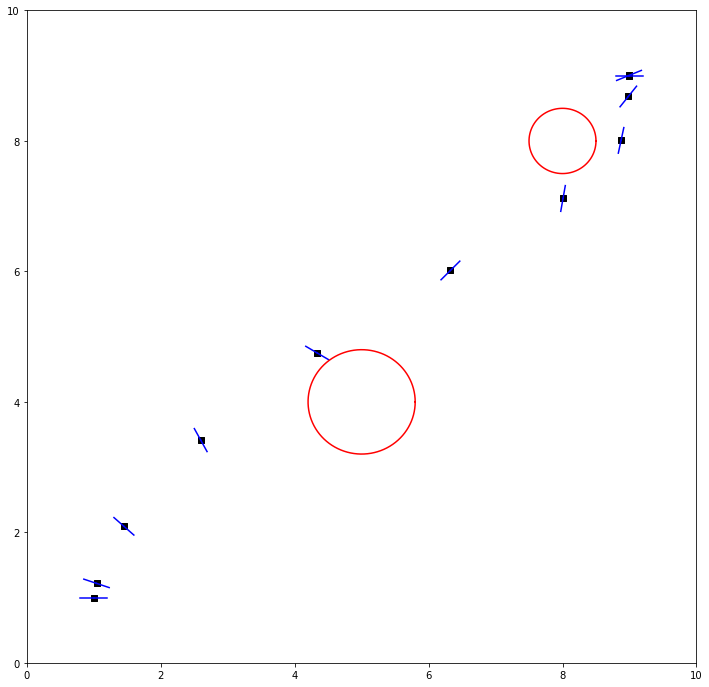

In [2]:
import numpy as np
import matplotlib.pyplot as plt




def plot_single_state(x, y, phi, L):
    r_propeller_x = x + L*np.cos(phi)
    r_propeller_y = y + L*np.sin(phi)

    l_propeller_x = x - L*np.cos(phi)
    l_propeller_y = y - L*np.sin(phi)


    fig = plt.figure(1)
    plt.scatter(x, y, marker='s')
    plt.plot([x, r_propeller_x], [y, r_propeller_y])
    plt.plot([x, l_propeller_x], [y, l_propeller_y])
    plt.xlim([0, 10])
    plt.ylim([0, 10])
    plt.show()


def plot_multiple_states(x, y, phi, L, obst):
    fig, ax = plt.subplots(figsize=(12,12))
    for (xk, yk, phik) in zip(x, y, phi):
        r_propeller_x = xk + L*np.cos(phik)
        r_propeller_y = yk + L*np.sin(phik)

        l_propeller_x = xk - L*np.cos(phik)
        l_propeller_y = yk - L*np.sin(phik)

        ax.scatter(xk, yk, marker='s', color = 'black')
        ax.plot([xk, r_propeller_x], [yk, r_propeller_y], 'b')
        ax.plot([xk, l_propeller_x], [yk, l_propeller_y], 'b')
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])
        
    for o in obst:
        px_obst_k = o[0][0]
        py_obst_k = o[0][1]
        r_obst_k = o[1]
        theta = c.linspace(0, 2*c.pi, 100)
        xobst1 = px_obst_k + r_obst_k*c.cos(theta)
        xobst2 = py_obst_k + r_obst_k*c.sin(theta)
        plt.plot(xobst1, xobst2, 'r')

    
    plt.show()


L = 0.2
step = 5
x = pxsol[0::step]
y = pysol[0::step]
phi = phisol[0::step]

# obst = ([p_obst1[0], p_obst2[0]], [p_obst1[1], p_obst2[1]], [r_obst1, r_obst2])

plot_multiple_states(x, y, phi, L, obstacles)
plt.show()